### Create Deep Learning/Keras Model for Practice Area Classification from Job Descriptions

This code file is for preparing and saving prediction data. 

These sections included(You can easily search with section title <'section number'>-<'name'><br>
    for example: to go number 4:search in the files with 4-Indexing word vectors<br><br>
1-Import Libraries <br>
2-Environment setting(Server:S, Local:L)<br>
3-Word embedding settings<br>
4-Index word vectors<br>
5-Reading and processing cleaned job descriptions from CSV file<br>
6-Save classnames.json<br>
7-Vectorize the text samples into a 2D integer tensor<br>
8-Split the data into a training set and a validation set<br>
9-Prepare embedding matrix<br>
10-Train a 1D convent with global maxpooling<br>
11-Show plots<br>
12-Save training result into CSV file<br>
13-Save model to disk<br>


Before running the code;<br>
-Note that the glove.6B data isn't checked into git. You need to download and unzip it separately.
https://nlp.stanford.edu/projects/glove/<br>
-Change your environment either server or local, and create these paths/folders for your environment(look at section number-2) <br>
    BASE_DIR,resultsdir <br>
-Import log4csv.py file is for saving your result logs(look at section number-12). Do not forget, if you see parameterdic dictionary list below, it is for saving logs.<br>


In [1]:
#1-Import Libraries
from __future__ import print_function
import matplotlib
import keras
import os
import pickle
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, CSVLogger
from keras.initializers import Constant
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import os
import datetime
import matplotlib.pyplot as plt
import uuid  #used for creating jobid for result logs


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#2-Environment setting(Server:S, Local:L)

#do not forget to change before running the program

environment = 'L' #environment L: Local  S:Server Server is for company's GPU


if environment == 'S':
    BASE_DIR = './'
    resultsdir = './store/'
    from log4csv import savelog4csv   #log4csv is my code, so It has to be in the same folder with KerasPracticeJD
    #Saving your logs int CSV is very easy with log4csv. Just edit  

    ##these configurations is for tensorflow settings
    os.environ["CUDA_VISIBLE_DEVICES"] = '1'  
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    keras.backend.set_session(sess)
elif environment == 'L':
    os.chdir("/Users/omerorhan/jdanalyzer/venv/Source")
    BASE_DIR = '/Users/omerorhan/jdanalyzer/gloves/'
    resultsdir = '/Users/omerorhan/jdanalyzer/gloves/'
    from log4csv import savelog4csv
###listofparameterdic is for our csv log file. we are storing parameters dictionary in the list.
#you can look log4csv.py to write logs into csvfiles. Just add parameter to parameterdic dictionarylist.
listofparameterdic = []
parameterdic = {}
parameterdic.update({"processdate": str(datetime.datetime.now())})


# first, build index mapping words in the embeddings set
# to their embedding vector
parameterdic.update({"jobid": str(str(uuid.uuid4().fields[-1])[:7])})


In [3]:
#3-Word embedding settings
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')  # glove.6B is our word vector. If you don't have it yet, 
#please download from Stanford. Look at the beginning of the file.  
MAX_SEQUENCE_LENGTH = 1000  #job description word length. 
MAX_NUM_WORDS = 20000 #maximum word number for embedding matrix
EMBEDDING_DIM = 200  #embedding_dim for glove.6B. If you change glove.6B, do not forget to change this limit.
VALIDATION_SPLIT = 0.2 #validation data size, so you have 0.8 train data.


In [4]:
#4-Index word vectors
#getting word vectors
print('Indexing word vectors.')
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.200d.txt')) as f: #word vector downloaded from Stanford. 
#Look at beginning of the file
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))
parameterdic.update({"word_vectors_count": str(len(embeddings_index))})
# second, prepare text samples and their labels


Indexing word vectors.


Found 400000 word vectors.


In [6]:
#5-Reading and processing cleaned job descriptions from csv file
print('Processing text dataset')
dataset = pd.read_csv(BASE_DIR + "traininggen.csv", engine='python', index_col=False)  #our cleaned job descriptions.
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

'''
Processing text dataset
['sales representative' 'administrative positions related to sales'
 'account executives and advisors' 'sales management']
'''
#Prepare the labels regarding to Sectors
listOfSectors = {"sales representative": 0, "administrative positions related to sales": 1,
                 "account executives and advisors": 2,
                 "sales management": 3,"executive-level management":4}

labels_index = listOfSectors

for index, row in dataset.iterrows():
    # label_id = len(labels_index)
    texts.append(row['Description'])
    labels.append(listOfSectors.get(row['Label']))


Processing text dataset


In [7]:
#6-Save classnames.json
# Save word_index separately so we can use it in runtime classifier
import json
with open(resultsdir + 'classnames.json',
          'w') as classnames_file:  
    json.dump(labels_index, classnames_file)

print('Found %s texts.' % len(texts))
parameterdic.update({"text_size": str(len(texts))})




Found 160 texts.


In [8]:
#7-Vectorize the text samples into a 2D integer tensor
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) #Tokenization is breaking the sentence into words and punctuation,
print('Starting fit_on_texts')
tokenizer.fit_on_texts(texts)
print('Starting texts_to_sequences')
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #padding for our MAX_SEQUENCE_LENGTH=1000
labels = to_categorical(np.asarray(labels))
parameterdic.update({"data_shape": str(data.shape)})
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)



Starting fit_on_texts
Starting texts_to_sequences
Found 4614 unique tokens.
Shape of data tensor: (160, 1000)
Shape of label tensor: (160, 5)


In [9]:
#8-Split the data into a training set and a validation set
#do not forget. VALIDATION_SPLIT was defined beginning of the program
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
print(labels)
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]



[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0.

In [10]:
#9-Prepare embedding matrix
print('Preparing embedding matrix.')
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)



Preparing embedding matrix.


In [11]:
import keras.backend as K

def precision(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0
    # How many selected items are relevant?
    precision = c1 / c2
    # How many relevant items are selected?
    return precision

def recall(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0
    # How many relevant items are selected?
    recall = c1 / c3
    return recall

def f1_score(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0
    # How many selected items are relevant?
    precision = c1 / c2
    # How many relevant items are selected?
    recall = c1 / c3
    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


In [12]:
#10-Train a 1D convnet with global maxpooling
print('Train model.')
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)  #Dropout: A Simple Way to Prevent Neural Networks from Overfitting
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='sigmoid')(x)

model = Model(sequence_input, preds)

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['categorical_accuracy', f1_score, precision, recall])
parameterdic.update({"model_loss": str(model.loss)})  #for csvlog files.
parameterdic.update({"model_optimizer": str(model.optimizer)})  #for csvlog files.
parameterdic.update({"model_metrics": str(model.metrics)})  #for csvlog files.
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=2, mode='max')
#early_stop:Stop training when a monitored quantity has stopped improving.

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=2,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop]
                    )

parameterdic.update({"early_stop_patience": str(early_stop.patience)})
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['categorical_accuracy']
valacc = history_dict['val_categorical_accuracy']

#print("f1_score:", np.round(history_dict['val_f1_score'][0],2))

#print("val_precision:", np.round(history_dict['val_precision'][0],2))

#print("val_recall:", np.round(history_dict['val_recall'][0],2))

#parameterdic.update({"f1_score": str(np.round(history_dict['val_f1_score'][0],2))})
#parameterdic.update({"precision": str(np.round(history_dict['val_precision'][0],2))})
#parameterdic.update({"recall": str(np.round(history_dict['val_recall'][0],2))})

'''
precision = history_dict['precision']
print("precision:", str(precision))
recall = history_dict['recall']
print("recall:", str(recall))
'''
epochs = range(1, len(acc) + 1)
parameterdic.update({"epochs": str(history.params.get('epochs'))})
parameterdic.update({"batch_size": str(history.params.get('batch_size'))})


Train model.


Train on 126 samples, validate on 31 samples
Epoch 1/2


126/126 [==============================] - 3s - loss: 1.0986 - categorical_accuracy: 0.0476 - f1_score: 0.2698 - precision: 0.1799 - recall: 0.5397 - val_loss: 0.6776 - val_categorical_accuracy: 0.1290 - val_f1_score: 0.2410 - val_precision: 0.1923 - val_recall: 0.3226


Epoch 2/2


126/126 [==============================] - 3s - loss: 0.6645 - categorical_accuracy: 0.1190 - f1_score: 0.1871 - precision: 0.1576 - recall: 0.2302 - val_loss: 0.5977 - val_categorical_accuracy: 0.4516 - val_f1_score: 0.0571 - val_precision: 0.2500 - val_recall: 0.0323

'''
csv_logger.params
csv_logger.validation_data
csv_logger.filename
historyframe = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=2,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stop, csv_logger]
                    ).history
'''

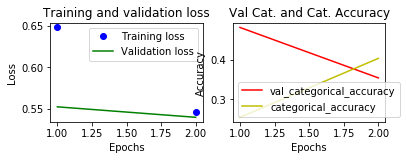

In [13]:
#11-Show plots
#show results with plot
plt.subplot(221)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(epochs, valacc, 'r', label='val_categorical_accuracy')
plt.plot(epochs, acc, 'y', label='categorical_accuracy')
plt.title('Val Cat. and Cat. Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plotpath = resultsdir + "plots/" + str(parameterdic.get("jobid")) + "Val.png"
plt.savefig(plotpath)
parameterdic.update({"plot_path": plotpath}) #you can see graph path in your csvlog file. 
plt.show()


In [14]:
#12-Save training result into CSV file
#Import log4csv.py file is for saving your result logs(look at section number-12). 
#Do not forget, if you see parameterdic dictionary list below, it is for saving logs.
parameterdic.update({"extra_info": "Change embeddings to 60B 100 d"}) #
listofparameterdic = []
listofparameterdic.append(parameterdic)
count = 0
print(count)
while len(history.history.get('val_loss')) > count:
    parameterdichist = {}
    for key, val in history.history.items():
        parameterdichist.update({key: history.history[key][count]})
    count = count + 1
    listofparameterdic.append(parameterdichist)
print(listofparameterdic)
savelog4csv(resultsdir, listofparameterdic)


0
[{'plot_path': '/Users/omerorhan/jdanalyzer/gloves/plots/2151908Val.png', 'model_loss': 'binary_crossentropy', 'processdate': '2019-02-27 12:36:09.220854', 'data_shape': '(157, 1000)', 'batch_size': '128', 'text_size': '157', 'model_optimizer': '<keras.optimizers.Adam object at 0x1205cee80>', 'extra_info': 'Change embeddings to 60B 100 d', 'epochs': '2', 'model_metrics': "['categorical_accuracy', <function f1_score at 0x119630268>, <function precision at 0x119630158>, <function recall at 0x119630048>]", 'word_vectors_count': '400000', 'jobid': '2151908', 'early_stop_patience': '2'}, {'loss': 0.64801990985870361, 'val_precision': 0.48387095332145691, 'val_categorical_accuracy': 0.48387095332145691, 'val_f1_score': 0.48387095332145691, 'categorical_accuracy': 0.25396826863288879, 'precision': 0.26923078298568726, 'recall': 0.1666666716337204, 'val_recall': 0.48387095332145691, 'val_loss': 0.55231618881225586, 'f1_score': 0.20588235557079315}, {'loss': 0.54654014110565186, 'val_precisio

In [15]:
#13-Save model to disk
print("Saving model to disk...")
keras.models.save_model(model, resultsdir + "model.h5")  # Save almost everything in one h5 file. What is missing:
with open(resultsdir + 'dictionary.json',
          'w') as dictionary_file:  # Save word_index separately so we can use it in runtime classifier
    json.dump(word_index, dictionary_file)
with open(resultsdir + 'tokenizer.pickle', 'wb') as tokenizer_file:  # Save entire tokenizer separately
    pickle.dump(tokenizer, tokenizer_file, protocol=pickle.HIGHEST_PROTOCOL)
# os.rename("code.log", resultsdir + "code.log")     # Move our code hyperparameter dump (made by bin/logexp script) to resultsdir
# os.rename("KerasPractice.py", resultsdir + "KerasPractice.py")        # Might as well copy all the code we used
print("Saved model and code to disk in directory " + resultsdir)


Saving model to disk...


Saved model and code to disk in directory /Users/omerorhan/jdanalyzer/gloves/
